In [5]:
import os
import gzip
import struct
import numpy as np
import random
import matplotlib.pyplot as plt
import keras
import cv2
import math

In [6]:
%matplotlib inline 

image_dir = 'C:/Users/Kan/Desktop/CharRecog/gzip'
labels = '0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz'
categories = len(labels)

model_path = 'C:/Users/Kan/Desktop/CharRecog/emnist-cnn-model-epoch20.h5'

In [7]:
def read_idx(filename):
    print('Processing data from %s.' % filename)
    with gzip.open(filename, 'rb') as f:
        z, dtype, dim = struct.unpack('>HBB', f.read(4))
        shape = tuple(struct.unpack('>I', f.read(4))[0] for d in range(dim))
        print('Shape:', shape)
        return np.frombuffer(f.read(), dtype=np.uint8).reshape(shape)

def load_emnist():
    test_images = os.path.join(image_dir, 'emnist-byclass-test-images-idx3-ubyte.gz')
    test_labels = os.path.join(image_dir, 'emnist-byclass-test-labels-idx1-ubyte.gz')

    test_X = read_idx(test_images)
    test_y = read_idx(test_labels)
    
    return (test_X, test_y)

raw_test_X, raw_test_y = load_emnist()


Processing data from C:/Users/Kan/Desktop/CharRecog/gzip\emnist-byclass-test-images-idx3-ubyte.gz.
Shape: (116323, 28, 28)
Processing data from C:/Users/Kan/Desktop/CharRecog/gzip\emnist-byclass-test-labels-idx1-ubyte.gz.
Shape: (116323,)


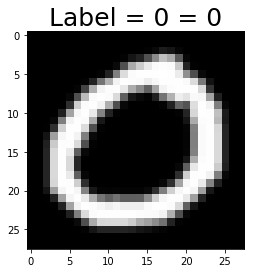

In [8]:
i = random.randint(0, raw_test_X.shape[0])
fig, ax = plt.subplots()
ax.clear()
ax.imshow(raw_test_X[i].T, cmap='gray')

title = 'Label = %d = %s' % (raw_test_y[i], labels[raw_test_y[i]])
ax.set_title(title, fontsize=25)

plt.show()

In [9]:
test_X = raw_test_X.astype('float32')

test_X /= 255

test_X = test_X.reshape(test_X.shape[0], 28, 28, 1)

In [10]:
test_y = keras.utils.np_utils.to_categorical(raw_test_y)

In [11]:
model = keras.models.Sequential()
model.add(keras.layers.Conv2D(32,
                kernel_size=(5, 5),
                strides=(2, 2),
                input_shape=(28, 28, 1),
                activation='relu'))
model.add(keras.layers.Conv2D(64,
                kernel_size=(3, 3),
                activation='relu'))
model.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(keras.layers.Dropout(0.25))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(128, activation='relu'))
model.add(keras.layers.Dropout(0.25))
model.add(keras.layers.Dense(categories, activation='softmax'))
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 12, 12, 32)        832       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 10, 10, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 5, 5, 64)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1600)              0         
_________________________________________________________________
dense_1 (Dense)      

In [12]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [13]:
model = keras.models.load_model(model_path)
print(model.layers)
results = model.evaluate(test_X, test_y)
print('Loss: %.2f%%, Accuracy: %.2f%%' % (results[0]*100, results[1]*100))

Instructions for updating:
Use tf.cast instead.
[<keras.layers.convolutional.Conv2D object at 0x00000152A3D18C18>, <keras.layers.convolutional.Conv2D object at 0x00000152A3D18F60>, <keras.layers.pooling.MaxPooling2D object at 0x00000152A3D25D30>, <keras.layers.core.Dropout object at 0x00000152A3D18F98>, <keras.layers.core.Flatten object at 0x00000152A3D3BB70>, <keras.layers.core.Dense object at 0x00000152A3D5AA90>, <keras.layers.core.Dropout object at 0x00000152A3D78C50>, <keras.layers.core.Dense object at 0x00000152A3D78780>]
116323/116323 [==============================] - 14s 119us/step
Loss: 34.83%, Accuracy: 86.93%


In [14]:
image='/Users/Kan/Desktop/CharRecog/p.png'
img = cv2.imread(image, cv2.IMREAD_GRAYSCALE)

In [15]:
h = np.shape(img)[1]
w = np.shape(img)[1]
print(h,w)
inputs = np.float32([[h,w],[0,w],[h,0],[0,0]])
outputs = np.float32([[28,28],[0,28],[28,0],[0,0]])
M = cv2.getPerspectiveTransform(inputs, outputs)
image_28 = cv2.warpPerspective(img, M, (28,28))

image_inverted =  cv2.bitwise_not(image_28)


100 100


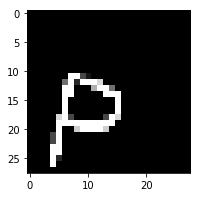

In [16]:

fig = plt.figure(figsize=(3,3))
plt.imshow(image_inverted, cmap='gray')
plt.show()

1/1 [==============================] - 0s 94ms/step


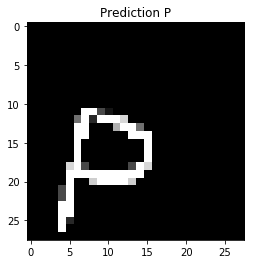

In [17]:
image_inverted_4d = image_inverted.copy()
image_inverted_4d = image_inverted_4d.reshape(-1,28, 28, 1)

result = np.round(model.predict(image_inverted_4d, verbose=1), decimals=2)
resultLabel = np.argmax(result, axis=1)

plt.imshow(image_inverted, cmap='gray')
plt.title('Prediction {}'.format(labels[resultLabel[0]]))
plt.show()